Your task is to create a **distributed** mixture_of_gaussians training algorithm using the rabbitmq framework and distributed expectation maxmiziation.

In [1]:
# if you don't have celery, you will need to install it
#!pip install celery

In [2]:
!sudo rabbitmqctl add_user myguest myguestpwd
!sudo rabbitmqctl set_permissions -p / myguest "." "." ".*"

Creating user "myguest" ...
Error: user_already_exists: myguest
Setting permissions for user "myguest" in vhost "/" ...


In [3]:
!sudo rabbitmqctl list_users

Listing users ...
guest	[administrator]
myguest	[]


In [4]:
import random
import numpy as np
import json
import time
from copy import deepcopy
from celery import group
from utils import plot_results, create_dataset, init_params
from gmm_worker import gmm_tasks, NumpyEncoder

In [5]:
# Let us create the dataset:
Xs=create_dataset()
#Xs=np.loadtxt(open("mog_dataset.csv", "rb"), delimiter=",")

[[ 2.03703015  5.13207141]
 [-1.64390827  4.26182864]
 [ 0.3907526   3.39519598]
 [ 2.45354032  2.12713365]
 [ 2.80057377  3.25607954]
 [ 0.88273093  3.28934353]
 [ 1.53413399  2.93775277]
 [-0.50741524  4.21727764]
 [ 0.90105961  1.89106661]]


In [6]:
n_samples, n_features=Xs.shape
print("The dataset has {} {}-dimensional sample points".format(n_samples,n_features))

The dataset has 120000 2-dimensional sample points


In [7]:
# We will fit three Gaussians using 4 workers
n_clusters=3
n_workers = 4

In [8]:
#Let us set up the initial mu, covariance, and pi values
mu, cov, pi = init_params()

[[ 1.  0.]
 [-5.  2.]
 [-2. -2.]]
(3, 2, 2)
[[[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]]
[0.33333333 0.33333333 0.33333333]


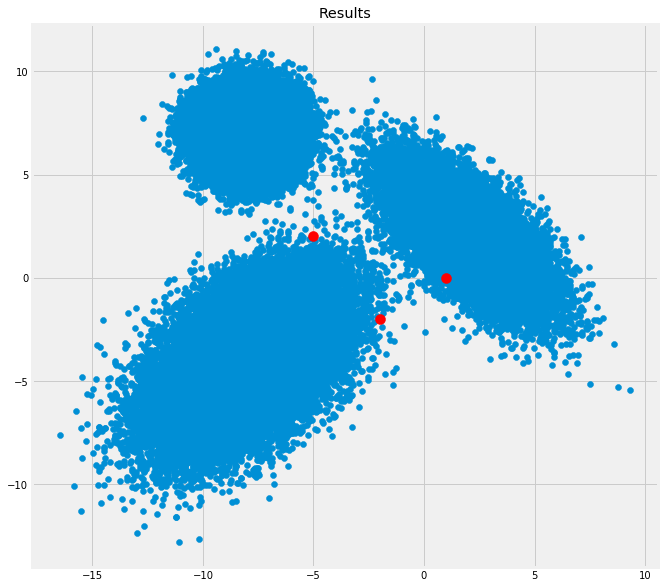

In [9]:
plot_results(Xs,mu=mu,cov=cov)

You will need to split this dataset into equal parts of same size, send these chunks to the workers, run EM updates on them, collect the results and update the parameters. Run 10 iterations and plot out the results. Visualize the updated mean and covariance matrices using the 'plot_results(Xs,mu=mu,cov=cov)' command.

In [49]:
n_workers = 2

n_each_worker = int(n_samples/ n_workers)
Xsubseqs = []
for i in range(n_workers):
    Xsubseqs.append(Xs[i*n_each_worker: (i+1)*n_each_worker])


In [50]:
Xsubseqs[0].shape

(60000, 2)

In [43]:
#celery -A gmm_worker worker --loglevel=info --concurrency=1

In [48]:
n_workers = 1

n_each_worker = int(n_samples/ n_workers)
Xsubseqs = []
for i in range(n_workers):
    Xsubseqs.append(Xs[i*n_each_worker: (i+1)*n_each_worker])

start_time = time.time()

n_iter = 10

response = group(gmm_tasks.s(task='data_to_workers', json_dump = json.dumps({'mus': mu, 'sigmas': cov,'pis': pi, 'n_features':n_features, "n_clusters": n_clusters, "X": seq}, cls=NumpyEncoder)) 
                                               for seq in Xsubseqs)() 
response.get()

for i in range(n_iter):
    E_res = group(gmm_tasks.s(task='E_step', json_dump = json.dumps({'sigmas': cov}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    Ri = E_res.get()
    
    partials_Ri=[json.loads(seq)['s'] for seq in Ri]
    
    partial_Ri = np.array(partials_Ri)
    
    R = np.sum(partial_Ri, axis = 0)
    
    
    M1_res = group(gmm_tasks.s(task='M_step1', json_dump = json.dumps({'R': R}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    
    partial_mu = M1_res.get()
    muis = [json.loads(seq)['muhats'] for seq in partial_mu]
    muis = np.array(muis)
    
    mu = np.sum(muis, axis = 0)
    pi = R/n_each_worker
    
    M3_res = group(gmm_tasks.s(task='M_step3', json_dump = json.dumps({'mus': mu, 'pis': pi}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)()
    
    partials_sigma = M3_res.get()
    partial_cov = [json.loads(seq)['sigmahats'] for seq in partials_sigma]
    covs = np.array(partial_cov)
    cov = np.sum(covs, axis = 0)
    
end_time = time.time()  
time_elapsed = end_time - start_time
print("Time used: {}".format(time_elapsed))
print("mu: ", mu)
print("cov: ", cov)
print("pi: ", pi)

Time used: 2242.185035943985
mu:  [[ 2.01274728  1.98752756]
 [-8.00113143  7.00386952]
 [-8.01696808 -4.00390205]]
cov:  [[[ 2.96261014e+00 -2.00161336e+00]
  [-2.00161336e+00  3.01725207e+00]]

 [[ 9.95555909e-01 -2.45845276e-04]
  [-2.45845276e-04  1.00267559e+00]]

 [[ 3.98920269e+00  1.99471847e+00]
  [ 1.99471847e+00  3.97495931e+00]]]
pi:  [0.16664195 0.50004521 0.33331284]


In [51]:
n_workers = 2

n_each_worker = int(n_samples/ n_workers)
Xsubseqs = []
for i in range(n_workers):
    Xsubseqs.append(Xs[i*n_each_worker: (i+1)*n_each_worker])

start_time = time.time()

n_iter = 10

response = group(gmm_tasks.s(task='data_to_workers', json_dump = json.dumps({'mus': mu, 'sigmas': cov,'pis': pi, 'n_features':n_features, "n_clusters": n_clusters, "X": seq}, cls=NumpyEncoder)) 
                                               for seq in Xsubseqs)() 
response.get()

for i in range(n_iter):
    E_res = group(gmm_tasks.s(task='E_step', json_dump = json.dumps({'sigmas': cov}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    Ri = E_res.get()
    
    partials_Ri=[json.loads(seq)['s'] for seq in Ri]
    
    partial_Ri = np.array(partials_Ri)
    
    R = np.sum(partial_Ri, axis = 0)
    
    
    M1_res = group(gmm_tasks.s(task='M_step1', json_dump = json.dumps({'R': R}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    
    partial_mu = M1_res.get()
    muis = [json.loads(seq)['muhats'] for seq in partial_mu]
    muis = np.array(muis)
    
    mu = np.sum(muis, axis = 0)
    pi = R/n_each_worker
    
    M3_res = group(gmm_tasks.s(task='M_step3', json_dump = json.dumps({'mus': mu, 'pis': pi}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)()
    
    partials_sigma = M3_res.get()
    partial_cov = [json.loads(seq)['sigmahats'] for seq in partials_sigma]
    covs = np.array(partial_cov)
    cov = np.sum(covs, axis = 0)
    
end_time = time.time()  
time_elapsed = end_time - start_time
print("Time used: {}".format(time_elapsed))
print("mu: ", mu)
print("cov: ", cov)
print("pi: ", pi)

Time used: 1103.0762548446655
mu:  [[ 2.01274728  1.98752756]
 [-8.00113143  7.00386952]
 [-8.01696808 -4.00390205]]
cov:  [[[ 2.96261014e+00 -2.00161336e+00]
  [-2.00161336e+00  3.01725207e+00]]

 [[ 9.95555909e-01 -2.45845276e-04]
  [-2.45845276e-04  1.00267559e+00]]

 [[ 3.98920269e+00  1.99471847e+00]
  [ 1.99471847e+00  3.97495931e+00]]]
pi:  [0.33328389 1.00009042 0.66662568]


In [52]:
n_workers = 3

n_each_worker = int(n_samples/ n_workers)
Xsubseqs = []
for i in range(n_workers):
    Xsubseqs.append(Xs[i*n_each_worker: (i+1)*n_each_worker])

start_time = time.time()

n_iter = 10

response = group(gmm_tasks.s(task='data_to_workers', json_dump = json.dumps({'mus': mu, 'sigmas': cov,'pis': pi, 'n_features':n_features, "n_clusters": n_clusters, "X": seq}, cls=NumpyEncoder)) 
                                               for seq in Xsubseqs)() 
response.get()

for i in range(n_iter):
    E_res = group(gmm_tasks.s(task='E_step', json_dump = json.dumps({'sigmas': cov}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    Ri = E_res.get()
    
    partials_Ri=[json.loads(seq)['s'] for seq in Ri]
    
    partial_Ri = np.array(partials_Ri)
    
    R = np.sum(partial_Ri, axis = 0)
    
    
    M1_res = group(gmm_tasks.s(task='M_step1', json_dump = json.dumps({'R': R}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    
    partial_mu = M1_res.get()
    muis = [json.loads(seq)['muhats'] for seq in partial_mu]
    muis = np.array(muis)
    
    mu = np.sum(muis, axis = 0)
    pi = R/n_each_worker
    
    M3_res = group(gmm_tasks.s(task='M_step3', json_dump = json.dumps({'mus': mu, 'pis': pi}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)()
    
    partials_sigma = M3_res.get()
    partial_cov = [json.loads(seq)['sigmahats'] for seq in partials_sigma]
    covs = np.array(partial_cov)
    cov = np.sum(covs, axis = 0)
    
end_time = time.time()  
time_elapsed = end_time - start_time
print("Time used: {}".format(time_elapsed))
print("mu: ", mu)
print("cov: ", cov)
print("pi: ", pi)

Time used: 747.5949041843414
mu:  [[ 2.01274728  1.98752756]
 [-8.00113143  7.00386952]
 [-8.01696808 -4.00390205]]
cov:  [[[ 2.96261014e+00 -2.00161336e+00]
  [-2.00161336e+00  3.01725207e+00]]

 [[ 9.95555909e-01 -2.45845276e-04]
  [-2.45845276e-04  1.00267559e+00]]

 [[ 3.98920269e+00  1.99471847e+00]
  [ 1.99471847e+00  3.97495931e+00]]]
pi:  [0.49992584 1.50013564 0.99993853]


In [57]:
n_workers = 4

n_each_worker = int(n_samples/ n_workers)
Xsubseqs = []
for i in range(n_workers):
    Xsubseqs.append(Xs[i*n_each_worker: (i+1)*n_each_worker])

start_time = time.time()

n_iter = 10

response = group(gmm_tasks.s(task='data_to_workers', json_dump = json.dumps({'mus': mu, 'sigmas': cov,'pis': pi, 'n_features':n_features, "n_clusters": n_clusters, "X": seq}, cls=NumpyEncoder)) 
                                               for seq in Xsubseqs)() 
response.get()

for i in range(n_iter):
    E_res = group(gmm_tasks.s(task='E_step', json_dump = json.dumps({'sigmas': cov}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    Ri = E_res.get()
    
    partials_Ri=[json.loads(seq)['s'] for seq in Ri]
    
    partial_Ri = np.array(partials_Ri)
    
    R = np.sum(partial_Ri, axis = 0)
    
    
    M1_res = group(gmm_tasks.s(task='M_step1', json_dump = json.dumps({'R': R}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    
    partial_mu = M1_res.get()
    muis = [json.loads(seq)['muhats'] for seq in partial_mu]
    muis = np.array(muis)
    
    mu = np.sum(muis, axis = 0)
    pi = R/n_each_worker
    
    M3_res = group(gmm_tasks.s(task='M_step3', json_dump = json.dumps({'mus': mu, 'pis': pi}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)()
    
    partials_sigma = M3_res.get()
    partial_cov = [json.loads(seq)['sigmahats'] for seq in partials_sigma]
    covs = np.array(partial_cov)
    cov = np.sum(covs, axis = 0)
    
end_time = time.time()  
time_elapsed = end_time - start_time
print("Time used: {}".format(time_elapsed))
print("mu: ", mu)
print("cov: ", cov)
print("pi: ", pi)

Time used: 550.9513370990753
mu:  [[ 2.01274728  1.98752756]
 [-8.00113143  7.00386952]
 [-8.01696808 -4.00390205]]
cov:  [[[ 2.96261014e+00 -2.00161336e+00]
  [-2.00161336e+00  3.01725207e+00]]

 [[ 9.95555909e-01 -2.45845276e-04]
  [-2.45845276e-04  1.00267559e+00]]

 [[ 3.98920269e+00  1.99471847e+00]
  [ 1.99471847e+00  3.97495931e+00]]]
pi:  [0.66656778 2.00018085 1.33325137]


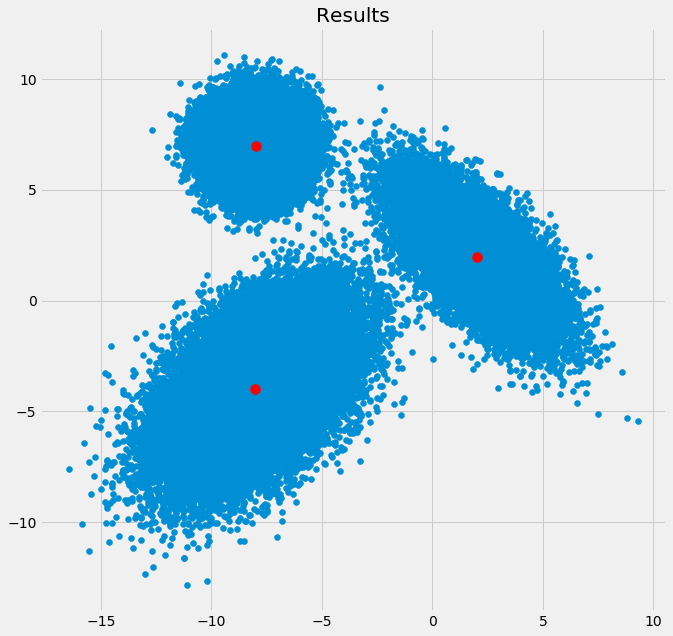

In [58]:
plot_results(Xs,mu=mu,cov=cov)

In [59]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from scipy.stats import multivariate_normal
import numpy as np

def plot_results_2(X, **kwargs):
    """Plot the dataset"""    
    
    fig = plt.figure(figsize=(10,10))
    ax0 = fig.add_subplot(111)
    ax0.scatter(X[:,0],X[:,1])
    ax0.set_title('Results')
    
    try:
        mu = kwargs['mu']
        for m in mu:
            ax0.scatter(m[0],m[1],c='red',zorder=10,s=100)
    except:
        pass
    
    try:
        random_indices = np.random.choice(X.shape[0], size=int(X.shape[0]*0.1), replace=False)
        X = X[random_indices, :]
        cov = kwargs ['cov']
        x,y = np.meshgrid(np.sort(X[:,0]),np.sort(X[:,1]))
        XY = np.array([x.flatten(),y.flatten()]).T
        reg_cov = 1e-6*np.identity(len(X[0,:]))
        
        for c,m in zip(cov,mu):
            c += reg_cov
            # let us set up the mean and covariance of a multi-dim gaussian
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax0.contour(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),colors='black',alpha=0.3)
                
    except:
        pass
    
    plt.show()
    fig.savefig('results_with_contour.png')


In [ ]:
plot_results_2(Xs, mu = mu, cov = cov)